# Program Assignment #3 - K-means clustering & Support Vector Machine
---

## Name: 李勝維
## Student ID: 0711239
---

In [321]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

# Data input & Data Preprocessing

In [322]:
from sklearn.preprocessing import LabelEncoder
# Wheat Seeds Dataset
import csv
# remove duplicate '\t's
with open("data/seeds_dataset.txt") as f:
    rows = list(csv.reader(f, delimiter="\t"))
    for row in rows:
        try:
            while True:
                row.remove("")
        except ValueError:
            pass
        row = [float(x) for x in row]
wheat_raw_data = np.array(rows, dtype=np.float32)
# shuffle data
np.random.shuffle(wheat_raw_data)
wheat_x, wheat_y = wheat_raw_data[..., :-1], wheat_raw_data[..., -1]
wheat_y = (wheat_y-1).astype(np.int32)

# Ionosphere Dataset
ion_raw_data = pd.read_csv("data/ionosphere.data").values
# shuffle data
np.random.shuffle(ion_raw_data)
ion_x, ion_y = ion_raw_data[..., :-1].astype(np.float32), ion_raw_data[..., -1]
ion_y_encoder = LabelEncoder() # transform 'g' -> 1, 'b' -> 0
ion_y = ion_y_encoder.fit_transform(ion_y)

# K-means Clustering

In [323]:
# K = 3
MAX_ITERATIONS = 1000
centers = wheat_x[np.random.randint(wheat_x.shape[0], size=3)]

for _ in range(MAX_ITERATIONS):
    # assignment step
    sets = [[] for _ in range(3)] # 3 empty sets
    for i, sample in enumerate(wheat_x):
        dist = [np.sum((sample - c)**2) for c in centers] # calculates distance to centers
        sets[np.argmin(dist)].append(i) # belongs to the set with minimum distance
    
    # update step
    centers = list()
    for i, set in enumerate(sets):
        point_set = wheat_x[set] # "set" stores only index
        centroid = np.mean(point_set, axis=0) # get center of mass for each set
        centers.append(centroid)

# get label by voting
KMEANS_centers = [None]*3
for i, set in enumerate(sets):
    labels = wheat_y[set]
    counts = np.bincount(labels)
    KMEANS_centers[np.argmax(counts)] = centers[i]

# utility for predicting
def KMeans_prediction(KMEANS_centers, x):
    # x.shape = (sample, feature)
    ans = list()
    for sample in x:
        dist = [np.sum((sample - c)**2) for c in KMEANS_centers]
        ans.append(np.argmin(dist))
    return np.array(ans, dtype=np.int32)

# Support Vector Machine + Parameter Search

In [324]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from tabulate import tabulate
whole_x_train, whole_x_test, whole_y_train, whole_y_test = train_test_split(ion_x, ion_y, test_size=0.3, random_state=0)

# function for parameter search
def test_hparam(kernel, gamma, degree=0, coef0=0):
    kf = KFold(n_splits=5)
    # for sdf in kf.split(x)
    model = SVC(kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, random_state=0)
    accs=list()
    for train_idx, test_idx in kf.split(whole_x_train):
        x_train, x_test, y_train, y_test = whole_x_train[train_idx], whole_x_train[test_idx], whole_y_train[train_idx], whole_y_train[test_idx]
        model.fit(x_train, y_train)
        accs.append(model.score(x_test, y_test))
    acc = sum(accs)/len(accs)
    if kernel=='poly':
        return gamma, degree, coef0, acc
    else:
        return gamma, acc

# parameter search
print("for kernel = poly")
kernel = 'poly'
counter = 1
table_header = ['poly #', 'gamma', 'degree', 'coef0', 'average performance (accuracy)']
table_data = list()
for gamma in (1/30, 1/35, 1/40):
    for degree in (2, 3, 4):
        for coef0 in (0.0, 0.5, 1.5):
            table_data.append([counter, *test_hparam(kernel, gamma, degree, coef0)])
            counter += 1
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
# best setting = gamma: 0.03, degree: 2, coef0: 1.5

print("\nfor kernel = rbf")
kernel = 'rbf'
counter = 1
table_header = ['rbf #', 'gamma', 'average performance (accuracy)']
table_data = list()
for gamma in (1/10, 1/35, 1/40):
    table_data.append([counter, *test_hparam(kernel=kernel, gamma=gamma)])
    counter += 1
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
# best setting =  gamma: 0.1

for kernel = poly
╒══════════╤═══════════╤══════════╤═════════╤══════════════════════════════════╕
│   poly # │     gamma │   degree │   coef0 │   average performance (accuracy) │
╞══════════╪═══════════╪══════════╪═════════╪══════════════════════════════════╡
│        1 │ 0.0333333 │        2 │     0   │                         0.787755 │
├──────────┼───────────┼──────────┼─────────┼──────────────────────────────────┤
│        2 │ 0.0333333 │        2 │     0.5 │                         0.865306 │
├──────────┼───────────┼──────────┼─────────┼──────────────────────────────────┤
│        3 │ 0.0333333 │        2 │     1.5 │                         0.873469 │
├──────────┼───────────┼──────────┼─────────┼──────────────────────────────────┤
│        4 │ 0.0333333 │        3 │     0   │                         0.673469 │
├──────────┼───────────┼──────────┼─────────┼──────────────────────────────────┤
│        5 │ 0.0333333 │        3 │     0.5 │                         0.869388 │
├─────────

We've obtained the best settings for each kernel:  
* poly: gamma: 0.03, degree: 2, coef0: 1.5  
* rbf: gamma: 0.1

Then, we construct different models with its best hyperparameter setting

In [325]:
# model construction
linear_svm = SVC(kernel='linear', random_state=0)
poly_svm = SVC(kernel='poly',gamma=0.03, degree=2, coef0=1.5, random_state=0)
rbf_svm = SVC(kernel='rbf', gamma=0.1, random_state=0)

# Results - K means

In [326]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
def show_multiclass_score(y_pred, y_test, y_label, silent=False):
    # shows metrics for each class
    table_data = list()
    table_header = []
    accuracy = accuracy_score(y_test, y_pred)
    recalls = recall_score(y_test, y_pred, average=None)
    precisions = precision_score(y_test, y_pred, average=None)
    table_header = ['Metrics', 'Accuracy', 'Recall', 'Precision']
    for name, recall, precision in zip(y_label, recalls, precisions):
        table_data.append([name,accuracy, recall, precision])
    if not silent:
        print(tabulate(table_data, table_header, tablefmt='fancy_grid'))

    return accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average='macro'), precision_score(y_test, y_pred, average='macro')

print("for K means:")
y_pred = KMeans_prediction(KMEANS_centers, wheat_x)
acc, recall, pres = show_multiclass_score(y_pred, wheat_y, ['label 1', 'label 2', 'label 3'])
c_m = confusion_matrix(wheat_y, y_pred)
table_data = list()
table_header = ['Confusion matrix', 'label 1', 'label 2', 'label 3']
for idx, row in enumerate(c_m):
    table_data.append([table_header[idx+1], *row])
print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
print(f"accuracy: {acc:4f}, average recall: {recall:4f}, average precision: {pres:4f}")

for K means:
╒═══════════╤════════════╤══════════╤═════════════╕
│ Metrics   │   Accuracy │   Recall │   Precision │
╞═══════════╪════════════╪══════════╪═════════════╡
│ label 1   │   0.890476 │ 0.814286 │    0.850746 │
├───────────┼────────────┼──────────┼─────────────┤
│ label 2   │   0.890476 │ 0.857143 │    0.983607 │
├───────────┼────────────┼──────────┼─────────────┤
│ label 3   │   0.890476 │ 1        │    0.853659 │
╘═══════════╧════════════╧══════════╧═════════════╛
╒════════════════════╤═══════════╤═══════════╤═══════════╕
│ Confusion matrix   │   label 1 │   label 2 │   label 3 │
╞════════════════════╪═══════════╪═══════════╪═══════════╡
│ label 1            │        57 │         1 │        12 │
├────────────────────┼───────────┼───────────┼───────────┤
│ label 2            │        10 │        60 │         0 │
├────────────────────┼───────────┼───────────┼───────────┤
│ label 3            │         0 │         0 │        70 │
╘════════════════════╧═══════════╧═══════════╧═

# Results - SVM

In [327]:
print("for SVMs: ")
for name, svm in zip(['linear_svm', 'poly_svm', 'rbf_svm'], [linear_svm, poly_svm, rbf_svm]):
    print(f"{name}:")
    svm.fit(whole_x_train, whole_y_train)
    y_pred = svm.predict(whole_x_test)
    acc, recall, pres = show_multiclass_score(y_pred, whole_y_test, ['b', 'g'])
    c_m = confusion_matrix(whole_y_test, y_pred)
    table_data = list()
    table_header = ['Confusion matrix', 'b', 'g']
    for idx, row in enumerate(c_m):
        table_data.append([table_header[idx+1], *row])
    print(tabulate(table_data, table_header, tablefmt='fancy_grid'))
    print(f"accuracy: {acc:4f}, average recall: {recall:4f}, average precision: {pres:4f}", end='\n\n')

for SVMs: 
linear_svm:
╒═══════════╤════════════╤══════════╤═════════════╕
│ Metrics   │   Accuracy │   Recall │   Precision │
╞═══════════╪════════════╪══════════╪═════════════╡
│ b         │   0.904762 │ 0.782609 │    1        │
├───────────┼────────────┼──────────┼─────────────┤
│ g         │   0.904762 │ 1        │    0.855072 │
╘═══════════╧════════════╧══════════╧═════════════╛
╒════════════════════╤═════╤═════╕
│ Confusion matrix   │   b │   g │
╞════════════════════╪═════╪═════╡
│ b                  │  36 │  10 │
├────────────────────┼─────┼─────┤
│ g                  │   0 │  59 │
╘════════════════════╧═════╧═════╛
accuracy: 0.904762, average recall: 0.891304, average precision: 0.927536

poly_svm:
╒═══════════╤════════════╤══════════╤═════════════╕
│ Metrics   │   Accuracy │   Recall │   Precision │
╞═══════════╪════════════╪══════════╪═════════════╡
│ b         │   0.885714 │  0.73913 │    1        │
├───────────┼────────────┼──────────┼─────────────┤
│ g         │   0.88571

# Comparison & Conclusion
透過自己實作K-means，練習了蠻多實作上的小細節；而在測試不同種的SVM的超參數設定，也讓我對於kernel function的影響有更多的想法

# Questions
## K-means Clustering: Choose two features to execute your K-means function and draw a scatter plot with the computed centers and the predicted label for each instance.

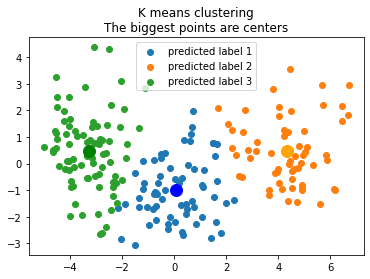

In [328]:
# using PCA to reduce dimension to 2 
from sklearn.decomposition import PCA
pca = PCA(2)
wheat_x = pca.fit_transform(wheat_x)
# K = 3
MAX_ITERATIONS = 1000
centers = wheat_x[np.random.randint(wheat_x.shape[0], size=3)]

for _ in range(MAX_ITERATIONS):
    # assignment step
    sets = [[] for _ in range(3)] # 3 empty sets
    for i, sample in enumerate(wheat_x):
        dist = [np.sum((sample - c)**2) for c in centers] # calculates distance to centers
        sets[np.argmin(dist)].append(i) # belongs to the set with minimum distance
    
    # update step
    centers = list()
    for i, set in enumerate(sets):
        point_set = wheat_x[set] # "set" stores only index
        centroid = np.mean(point_set, axis=0) # get center of mass for each set
        centers.append(centroid)

# get label by voting
KMEANS_centers = [None]*3
for i, set in enumerate(sets):
    labels = wheat_y[set]
    counts = np.bincount(labels)
    KMEANS_centers[np.argmax(counts)] = centers[i]

# plot points
plt.figure()
cmap = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['predicted label 1', 'predicted label 2', 'predicted label 3']
sets = [sets[2], sets[0], sets[1]] # order by label
for c, set, label in zip(cmap, sets, labels): 
    plt.scatter(wheat_x[set, 0], wheat_x[set, 1], c=c, label=label)

# plot center
cmap = ['blue', 'orange', 'green']
labels = ['center 1', 'center 2', 'center 3']
for c, center, label in zip(cmap, KMEANS_centers, labels):
    plt.scatter(*center, s=12**2 , c=c)
plt.title("K means clustering\nThe biggest points are centers")
plt.legend()
plt.show()

## Support Vector Machine: Show the average performance of K-fold cross-validation of parameter search in tables for each kernel.  
Shown above.